In [7]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
nltk.download('punkt')
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import sys
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
import warnings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
data = pd.read_csv("/content/drive/MyDrive/data/Songs.csv")
data.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


In [4]:
print("Artists in the data:\n",data.Artist.value_counts()) 

Artists in the data:
 Taylor Swift          50
Eric Clapton          50
David Bowie           50
Billie Eilish         50
Leonard Cohen         50
Billy Joel            50
Bruce Springsteen     40
The Beatles           35
Queen                 30
Bryan Adams           30
Lana Del Rey          30
John Denver           30
Ray LaMontagne        30
Vance Joy             30
Frank Sinatra         30
​twenty one pilots    30
George Michael        30
Nat King Cole         30
Elton John            30
Ed Sheeran            20
Bob Dylan             20
Name: Artist, dtype: int64


In [5]:
#Printing the size of dataset
print("Size of Dataset:",data.shape)

Size of Dataset: (745, 3)


In [8]:
data["No_of_Characters"] = data["Lyrics"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
data["No_of_Lines"] = data["Lyrics"].str.split('\n').apply(len)
data.describe()

,No_of_Characters,No_of_Words,No_of_Lines
count,745.000000,745.000000,745.000000
mean,1403.347651,319.338255,46.277852
std,666.721467,156.067038,21.180531
min,1.000000,1.000000,1.000000
25%,946.000000,215.000000,33.000000
50%,1289.000000,291.000000,44.000000
75%,1714.000000,389.000000,56.000000
max,7267.000000,1652.000000,224.000000


<Figure size 1080x1080 with 0 Axes>

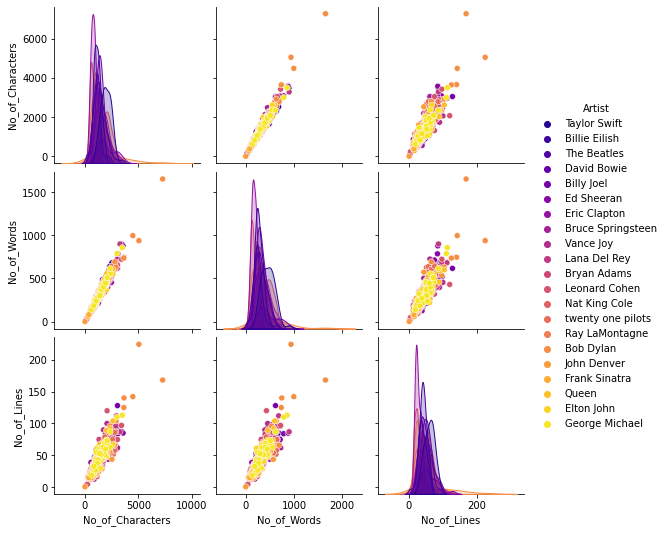

In [9]:
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, hue="Artist", palette="plasma")

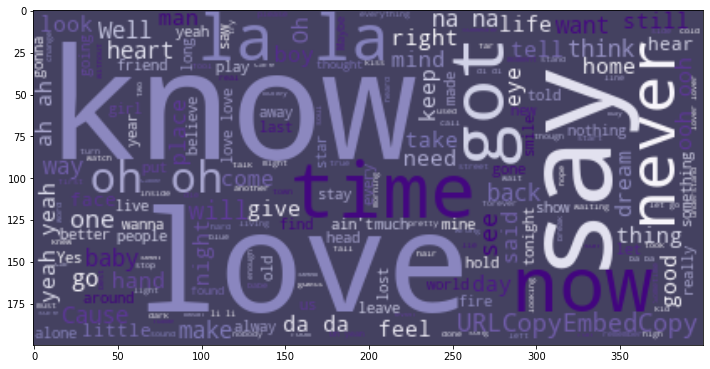

In [10]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(data["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

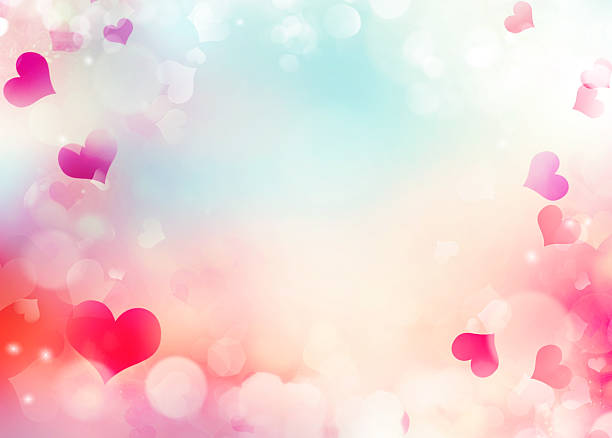

In [13]:
#A function to disply the song in an asthetically pleasing way! lol
def My_song(song):
    img = Image.open("/content/drive/MyDrive/data/istockphoto-622066398-612x612.jpg")
    Text_on_image = ImageDraw.Draw(img)
    myFont = ImageFont.truetype("/content/drive/MyDrive/data/DancingScript-VariableFont_wght.ttf", 45)
    Text_on_image.text((620,90), song, font=myFont, fill =(255, 255, 255))
    return img    
#Having a look at the first 500 charachters of a random song lyrics
My_song(data.Lyrics[42][:500])

In [14]:
Corpus =''
for listitem in data.Lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 92


In [15]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ', 'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', '…', '\u205f', '\ufeff']


In [16]:
#Keeping only a limited set of characters. 
to_remove = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', 
             '…', '\u205f', '\ufeff', '!', '&', '(', ')', '*', '-',  '/', ]
for symbol in to_remove:
    Corpus = Corpus.replace(symbol," ")

In [17]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [18]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 1045494
Number of unique characters: 47


In [19]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 1045454


In [20]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

In [23]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
model.compile(optimizer = 'adam',loss='categorical_crossentropy')

#Model's Summary               
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense_1 (Dense)             (None, 47)                12079     
                                                                 
Total params: 276,271
Trainable params: 276,271
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
3326/8168 [===========>..................] - ETA: 21:20 - loss: 2.7914

In [ ]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

In [ ]:
song_1 = Lyrics_Generator("the shoe shrunk, and the school belt got ridiculously petit", 400)
#Let's have a look at the song
My_song(song_1)

In [ ]:
song_2 = Lyrics_Generator("i'm a sunflower, a little funny", 400)
#Let's have a look at the song
My_song(song_2)